# Inversion of a sphere based on gravity response
# ( Implement in NumPy and PyMC3)

install PyMC follow instruction [https://github.com/pymc-devs/pymc]

This is a simple example for the probabilistic inversion of a classical geophysical example: the inversion of a sphere in the subsurface with a different density to the environment based on observed gravity data.

We start with the simplest possible case of only one observation (directly above the sphere) and only depth as an uncertain variable and then make the model progressively more complex.

In [2]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
# import tensorflow as tf
# import tensorflow_probability as tfp
# from tensorflow_probability import edward2 as ed
# tfd = tfp.distributions

# import seaborn as sns
import pandas as pd
%matplotlib inline

np.random.seed(111)
# tf.set_random_seed(111)


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

We now calculate the effect of this density contrast that would be observed on the surface. This is a well-studied example with an analytical solution:

$$g(x) = 10^5 \;\frac{4}{3} \,\pi \;\frac{r^3 \,\Delta \rho\, G\, z}
{\sqrt{\left( x^2 + z^2\right)^3}}$$

where:

- $z$ is the vertical position of the center of the sphere (lateral position at origin),
- $r$ its radius,
- $\Delta \rho$ the density difference to the surrounding domain,
- $G$ the gravitational constant,
- and $x$ the position at which the gravitational acceleration is calculated.


In [4]:
def grav_analytical(x, sphere_center, sphere_radius, density_difference):
    """Calculate gravitational effect of a sphere, measured at surface
    
    **Arguments**:
    - 'x' = scalar or np.array: position(s) of observation
    - 'sphere_center' = float: is the vertical position of the center of the sphere (lateral position at origin)
    - 'sphere_radius' = float: sphere radius
    - 'density_difference' = float: density difference to the surrounding domain
    """
    G=6.67e-11 # gravitational constant
    return ((4/3)*np.pi * (sphere_radius**3) * density_difference
            * G * sphere_center/(x**2 + sphere_center**2)**(3/2)) * 1e5


## Geometric model

We consider here a sphere in the subsurface with a different density. 

spherical point mass

In [5]:
#True model

sphere_center_true = 300. #m 
density_difference_true = 500. # kg/m^3: density diffrence to surrounding domain
sphere_radius_true = 100. #m

truevalue_list = [sphere_center_true,density_difference_true,sphere_radius_true]
x_domain=np.linspace(-1000,1000,101) #m

In [6]:
x_obs = np.linspace(-250., 250., 11)
grav_all = grav_analytical(x_domain, sphere_center_true, sphere_radius_true, density_difference_true)
grav_obs_array = grav_analytical(x_obs, sphere_center_true, sphere_radius_true, density_difference_true)
noise = norm(0,0.01).rvs(len(grav_obs_array))
grav_obs_array_withnoise = grav_obs_array +noise

plot noisy data

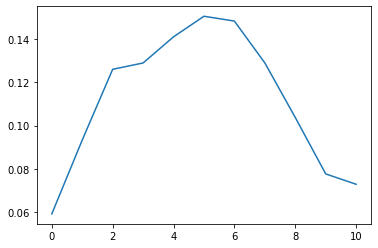

In [7]:
plt.plot(grav_obs_array_withnoise)

Plot the 3D sphere in 2D cross-section

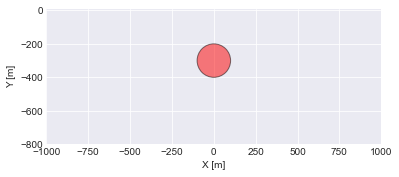

In [23]:
def plot_model():
    plt.figure(figsize=(6,4))

    plt.style.use('seaborn-darkgrid')
    ax = plt.subplot(aspect='equal') 

    # create circle object as matplotlib patch
    circle1 = plt.Circle((0, -sphere_center_true), sphere_radius_true, 
                        facecolor='r', edgecolor='k', alpha=0.5)

    ax.add_artist(circle1)

    # set model domain
    ax.set_xlim([-1000,1000])
    ax.set_ylim([-800,10])

    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")

    # plt.savefig("gravity_model.png")

plot_model()

plot the analytical gravity and noisy observation

(-1000.0, 1000.0)

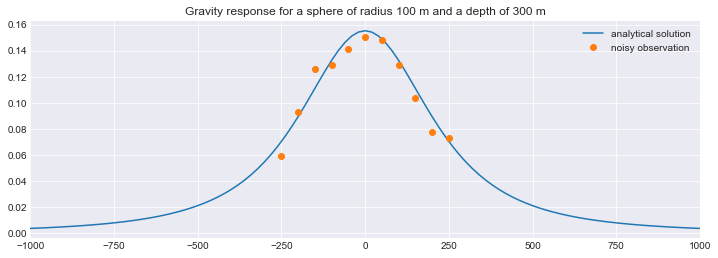

In [9]:
plt.figure(figsize=(12,4))
plt.plot(x_domain, grav_all,label="analytical solution", alpha=1)
plt.plot(x_obs, grav_obs_array_withnoise, 'o', label="noisy observation")
plt.title("Gravity response for a sphere of radius 100 m and a depth of 300 m")
plt.legend()
plt.xlim([-1000,1000])

### Algorithm Flowing hIPPYlib MCMC http://g2s3.com/labs/notebooks/SubsurfaceBayesian.html

Bayes’s Theorem

\begin{equation}
d \mu_{\mathrm{post}}\left(m | \mathbf{d}_{\mathrm{obs}}\right) \propto \pi_{\mathrm{like}}\left(\mathbf{d}_{\mathrm{obs}} | \mathrm{m}\right) \mathrm{d} \mu_{\mathrm{prior}}(\mathrm{m})
\end{equation}

Define the Prior
\begin{equation}
\mu_{\text {prior }} \sim \mathcal{N}\left(m_{\text {prior }}, C_{\text {prior }}\right)
\end{equation}

In [69]:
# sphere_center, density_difference, sphere_radius

mu_prior = [280., 480., 80.]
mu_prior = [500., 200., 250.]



cov = [[ 10,  0.,  0.],
        [ 0.,  10, 0.],
        [ 0., 0.,  10]]


Create the likelihood variance matrix, here we use a simple diagonal matrix with diagonal elements all equal to 0.01 

In [70]:
eye = np.eye(x_obs.shape[0])
likelihood_cov = 0.01 * eye
pd.set_option('display.float_format', '{:.2f}'.format)
print(pd.DataFrame(likelihood_cov)) # use pandas to pretty print matrix

     0    1    2    3    4    5    6    7    8    9    10
0  0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
1  0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
2  0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
3  0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00 0.00
4  0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00 0.00
5  0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00 0.00
6  0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00 0.00
7  0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00 0.00
8  0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00 0.00
9  0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01 0.00
10 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.01


In [71]:
xvals =[]
norm_list =[]

Plot the Prior distribution 

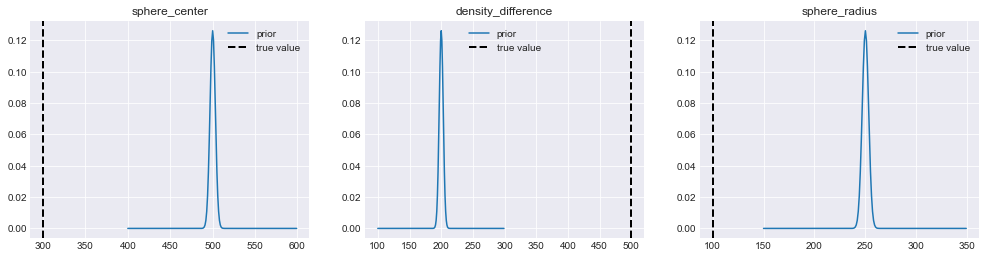

In [72]:
for i in range(3):
    xvals.append(np.arange(mu_prior[i]-100,mu_prior[i]+100))
    norm_list.append(norm.pdf(xvals[i],mu_prior[i],np.sqrt(cov[i][i])))
    
np.shape(xvals)

name_list = ["sphere_center", "density_difference", "sphere_radius"]

fig, axes = plt.subplots(1, 3, sharex='col', sharey='col')
fig.set_size_inches(17, 4)

for i in range(3):
    
    axes[i].plot(xvals[i], norm_list[i],label="prior")
    axes[i].title.set_text(name_list[i])
    axes[i].axvline(truevalue_list[i], label="true value", color='k', 
            linestyle='--', linewidth=2)
    axes[i].legend()

    

Define the Likelihood
\begin{equation}
\mathbf{d}_{\mathrm{obs}}=\mathbf{f}(\mathrm{m})+\mathbf{e}, \quad \mathbf{e} \sim \mathcal{N}\left(\mathbf{0}, \mathbf{\Gamma}_{\mathrm{noise}}\right)
\end{equation}
\begin{equation}
\pi_{\text {like }}\left(\mathbf{d}_{\text {obs }} | \mathrm{m}\right)=\exp \left(-\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\text {obs }}\right\|_{\Gamma_{\text {noise }}^{-1}}^{2}\right)
\end{equation}

In [73]:

with pm.Model() as model:
    # define prior as Normal distributions
    sc = pm.Normal("sphere_center", mu=280, sigma=10)
    dd = pm.Normal("density_difference", mu=480, sigma=10)
    sr = pm.Normal("sphere_radius", mu=80, sigma=10)
    
    G=6.67e-11 # gravitational constant
    
    # gravity forward function
    gravity = ((4/3)*np.pi * (sr**3) * dd* G 
               * sc/(x_obs**2 + sc**2)**(3/2)) * 1e5 
    # define likelihood function, as a MultiVariateNormal distribution
    obs = pm.MvNormal("obs", mu=gravity, cov=likelihood_cov, observed=grav_obs_array_withnoise)
    trace = pm.sample(1000, return_inferencedata=True)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sphere_radius, density_difference, sphere_center]
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


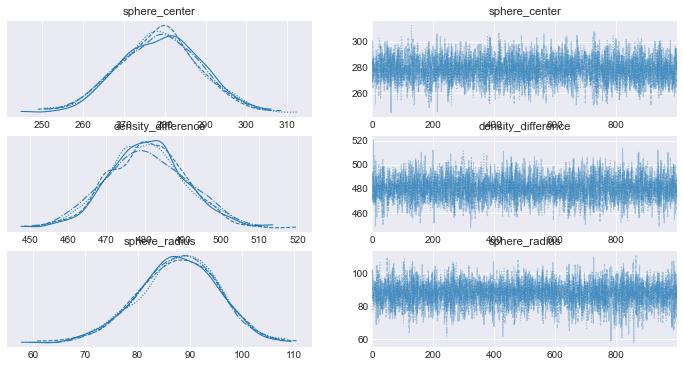

In [74]:
import arviz as az
az.plot_trace(trace);

#### The posterior


\begin{equation}
d \mu_{\mathrm{post}}\left(m | \mathbf{d}_{\mathrm{obs}}\right) \propto \exp \left(-\frac{1}{2}\left\|\mathbf{f}(\mathrm{m})-\mathbf{d}_{\mathrm{obs}}\right\|_{\mathrm{\Gamma}_{\mathrm{noise}}^{-1}}^{2}-\frac{1}{2}\left\|\mathrm{m}-\mathrm{m}_{\mathrm{prior}}\right\|_{C_{\mathrm{prior}}^{-1}}^{2}\right)
\end{equation}

In [75]:
trace.posterior['sphere_center'][0,0].data

array(268.86655962)

In [76]:
trace.posterior

<xarray.Dataset>
Dimensions:             (chain: 4, draw: 1000)
Coordinates:
  * chain               (chain) int64 0 1 2 3
  * draw                (draw) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
Data variables:
    sphere_center       (chain, draw) float64 268.9 274.3 286.3 ... 277.5 285.8
    density_difference  (chain, draw) float64 470.7 477.6 482.0 ... 488.2 487.9
    sphere_radius       (chain, draw) float64 102.0 94.96 84.34 ... 79.05 78.66
Attributes:
    created_at:                 2022-04-22T11:33:54.460000
    arviz_version:              0.11.4
    inference_library:          pymc3
    inference_library_version:  3.11.2
    sampling_time:              15.270771980285645
    tuning_steps:               1000

In [77]:
def plot_model_i(i = 0):
    plt.figure(figsize=(12,5))

    plt.style.use('seaborn-darkgrid')
    ax = plt.subplot(aspect='equal') 

    # create circle object as matplotlib patch
    circle1 = plt.Circle((0, -trace.posterior['sphere_center'][0,i].data), trace.posterior['sphere_radius'][0,i].data, 
                        facecolor='r', edgecolor='k', alpha=0.5)

    ax.add_artist(circle1)

    # set model domain
    ax.set_xlim([-1000,1000])
    ax.set_ylim([-800,10])

    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")

    # plt.savefig("gravity_model.png")

# plot_model_i(10)

In [81]:
interact(plot_model_i, i=widgets.IntSlider(min=0, max=990, step=10, value=0));

interactive(children=(IntSlider(value=0, description='i', max=990, step=10), Output()), _dom_classes=('widget-…

In [79]:
# Multiple realisations:
def plot_model_mult():
    plt.figure(figsize=(12,5))

    plt.style.use('seaborn-darkgrid')
    ax = plt.subplot(aspect='equal') 

    for i in range(1000):

        # create circle object as matplotlib patch
        circle1 = plt.Circle((0, -trace.posterior['sphere_center'][0,i].data), trace.posterior['sphere_radius'][0,i].data, 
                            facecolor='r', edgecolor='r', alpha=0.005)

        ax.add_artist(circle1)

    # set model domain
    ax.set_xlim([-1000,1000])
    ax.set_ylim([-800,10])

    ax.set_xlabel("X [m]")
    ax.set_ylabel("Y [m]")

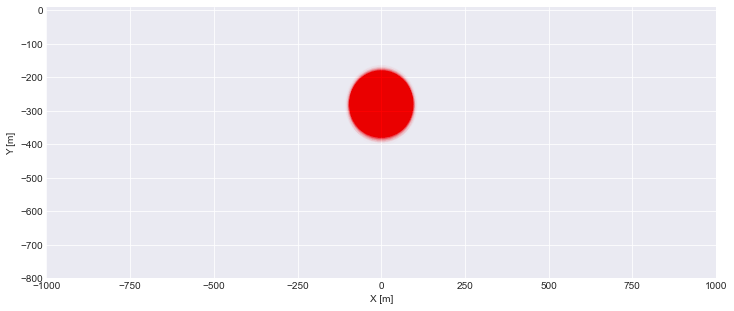

In [80]:
plot_model_mult()